In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pickle

sys.path.append(os.path.abspath("../analysis_tools/"))
from utils import * 

# pycytominer imports
from pycytominer import aggregate, annotate, normalize, feature_select
from pycytominer import feature_select

# load first few rows from parquet
import fastparquet

# for median absolute deviation
import scipy.stats as ss

# for Louvain clustering
import community as community_louvain
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sp
import scipy.spatial as spt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# make cell crops
import skimage.io

# for legends heatmap annotations
from matplotlib.patches import Patch, RegularPolygon, Polygon
import matplotlib.lines as mlines

# upset plots
from upsetplot import generate_counts, plot
from upsetplot import UpSet


In [2]:
# Define one way to color variants, use when highlighting specific variants
variant_type_palette = \
    {
        'Single Missense':'grey',
        'Synonymous':'green',
        'WT':'grey', 
        'Frameshift':'purple', 
        '3nt Deletion':'grey', 
        'Nonsense':'purple', 
        'Other':'grey'
    }

# Define mutational types in dataset
mutation_types = ['Single Missense','Frameshift','Synonymous']


In [3]:
# Import profiles
# R1
# Save profiles
df_profiles_R1 = \
    pd.read_csv('./R1_features/R1_variant_profiles_medianplusEMD_selected_nopunctaline_010425.csv')
df_profiles_R1.drop(columns='Unnamed: 0',inplace=True)
feat_selected_R1 = [s for s in df_profiles_R1.columns\
                                if s not in ['Variant',
                                             'Variant_Class',
                                             'Metadata_Object_Count',
                                             'UMAP1',
                                             'UMAP2']
                   ]
var_R1 = df_profiles_R1.Variant
df_profiles_R1.drop(columns='Variant',inplace=True)
df_profiles_R1.index = var_R1

# R2
df_profiles_R2 = \
    pd.read_csv('./R2_features/R2_variant_profiles_medianplusEMD_selected_nopunctaline_010425.csv')
df_profiles_R2.drop(columns='Unnamed: 0')
feat_selected_R2 = [s for s in df_profiles_R2.columns\
                                if s not in ['Variant',
                                             'Variant_Class',
                                             'Metadata_Object_Count',
                                             'UMAP1',
                                             'UMAP2']
                   ]
var_R2 = df_profiles_R2.Variant
df_profiles_R2.drop(columns='Variant',inplace=True)
df_profiles_R2.index = var_R2

# merge by taking average
var_common = list(set(var_R1).intersection(set(var_R2)))
feat_common = list(set(feat_selected_R1).intersection(set(feat_selected_R2)))
df_profiles_merged = \
    (df_profiles_R1.loc[var_common,feat_common] + df_profiles_R2.loc[var_common,feat_common])/2 #Average profiles
df_profiles_merged['NCells_R1'] = df_profiles_R1.loc[var_common,'Metadata_Object_Count']
df_profiles_merged['NCells_R2'] = df_profiles_R2.loc[var_common,'Metadata_Object_Count']
df_profiles_merged.reset_index(inplace=True)
df_profiles_merged['Variant_Class'] = \
    pd.Categorical(df_profiles_merged['Variant'].astype(str).apply(variant_classification),
                       categories=mutation_types, ordered=True)


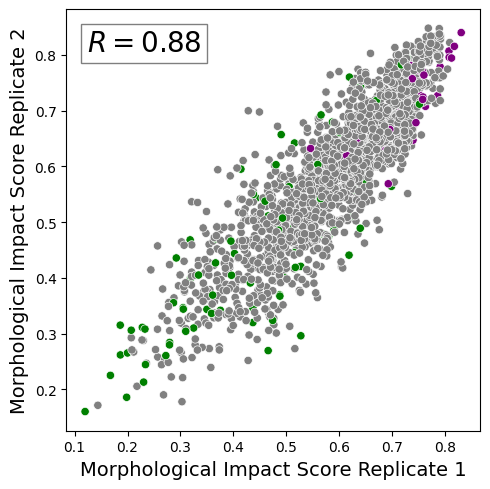

In [4]:
# Plot correlation between impact scores for replicates
df_profiles_R1_synmedian = \
    df_profiles_R1\
        .query('Variant_Class == "Synonymous"')\
        [feat_common].agg(np.median)
variant_cosine_similarity_R1 = \
    cosine_similarity(df_profiles_R1[feat_common], df_profiles_R1_synmedian.values.reshape(1,-1))
df_profiles_R1['Morphological Impact Score'] = \
    (1-variant_cosine_similarity_R1[:,0])/2

df_profiles_R2_synmedian = \
    df_profiles_R2\
        .query('Variant_Class == "Synonymous"')\
        [feat_common].agg(np.median)
variant_cosine_similarity_R2 = \
    cosine_similarity(df_profiles_R2[feat_common], df_profiles_R2_synmedian.values.reshape(1,-1))
df_profiles_R2['Morphological Impact Score'] = \
    (1-variant_cosine_similarity_R2[:,0])/2

# Compute correlation plot between morphological impact scores
# Compute linear regression parameters
r1_mis = df_profiles_R1.loc[var_common,'Morphological Impact Score']
r2_mis = df_profiles_R2.loc[var_common,'Morphological Impact Score']

slope, intercept, r_value, p_value, std_err = ss.linregress(r1_mis,r2_mis)

# Prepare line values for the best-fit line
line_x = np.linspace(r1_mis.min(), r1_mis.max(), 100)
line_y = slope * line_x + intercept

# Plot
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=r1_mis, 
                y=r2_mis, 
                hue=df_profiles_R1.loc[var_common,'Variant_Class'],
                palette=variant_type_palette,
                ax=ax,
                legend=False)
#ax.plot(line_x, line_y, color='red')

# Add labels
ax.set_xlabel('Morphological Impact Score Replicate 1', fontsize=14)
ax.set_ylabel('Morphological Impact Score Replicate 2', fontsize=14)

# Display R^2 on the plot
ax.text(
    0.05, 0.9, 
    f'$R = {r_value:.2f}$', 
    transform=ax.transAxes, 
    fontsize=20, 
    bbox=dict(facecolor='white', alpha=0.5)
)

# Show legend and plot
#ax.legend(loc='lower right', markerscale=2)
plt.tight_layout()
fig.savefig('./consensus_plots/LMNAT3.morphologicalimpactscore.correlationbetweenreps.011325.pdf')
plt.show()



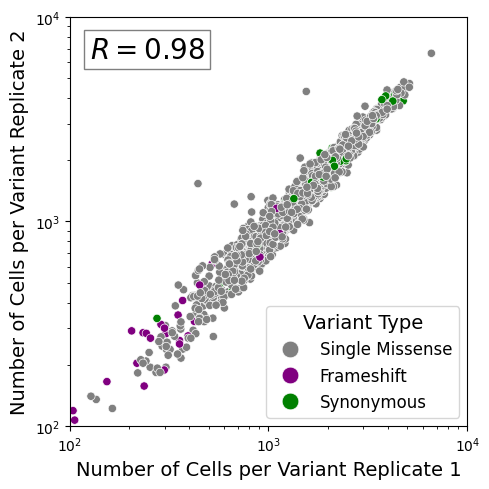

In [5]:
# Plot correlation between NCells for replicates
# Compute correlation plot 
# Compute linear regression parameters
r1_ncells = df_profiles_merged['NCells_R1']
r2_ncells = df_profiles_merged['NCells_R2']

slope, intercept, r_value, p_value, std_err = ss.linregress(r1_ncells, r2_ncells)

# Prepare line values for the best-fit line
line_x = np.linspace(r1_ncells.min(), r1_ncells.max(), 100)
line_y = slope * line_x + intercept

# Plot
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=r1_ncells, 
                y=r2_ncells, 
                hue=df_profiles_merged['Variant_Class'],
                palette=variant_type_palette,
                ax=ax,
                )
#ax.plot(line_x, line_y, color='red', label='Best Fit Line')

# Add labels
ax.set_xlabel('Number of Cells per Variant Replicate 1', fontsize=14)
ax.set_ylabel('Number of Cells per Variant Replicate 2', fontsize=14)

# Display R^2 on the plot
ax.text(
    0.05, 0.9, 
    f'$R = {r_value:.2f}$', 
    transform=ax.transAxes, 
    fontsize=20, 
    bbox=dict(facecolor='white', alpha=0.5)
)

# Show legend and plot
ax.legend(loc='lower right', markerscale=2, title='Variant Type', title_fontsize=14, fontsize=12)
ax.set_xlim(100,10000)
ax.set_ylim(100,10000)
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
fig.savefig('./consensus_plots/LMNAT3.ncellspervariant.correlationbetweenreps.011325.pdf')
plt.show()



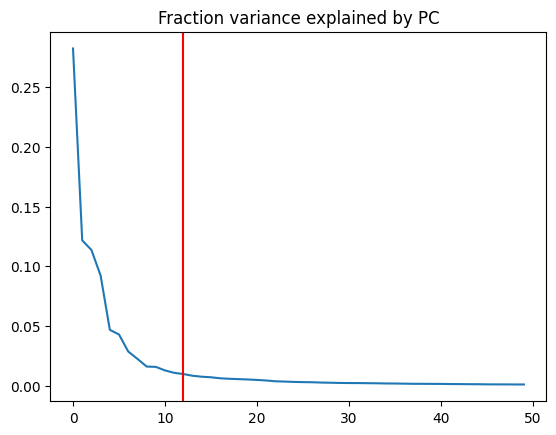

PCA dimensions: 12


In [20]:
# Perform PCA to get fraction variance explained plot
n_comp_pca_test=50
pca = PCA(n_components=n_comp_pca_test)
variant_medianplusemd_scaled = df_profiles_merged[feat_common].values
variant_medianplusemd_pca = pca.fit_transform(variant_medianplusemd_scaled)

# Plot fraction variance explained
plt.plot(list(range(n_comp_pca_test)), pca.explained_variance_ratio_)
plt.title('Fraction variance explained by PC')

# choose number of PCA dim to explain >80% of variance
var_explained_thresh = 0.80
pca_var_explained = np.asarray([np.sum(pca.explained_variance_ratio_[:i]) for i in range(n_comp_pca_test)])
n_comp_pca=sum(pca_var_explained <= var_explained_thresh)
plt.axvline(x=n_comp_pca, c='r')
plt.show()

# perform PCA again
print('PCA dimensions: ' + str(n_comp_pca))
pca = PCA(n_components=n_comp_pca)
variant_medianplusemd_pca = pca.fit_transform(variant_medianplusemd_scaled)
df_variant_medianplusEMD_features_pca = \
    pd.DataFrame(data = variant_medianplusemd_pca, 
                 columns=['PC'+str(i+1) for i in range(n_comp_pca)])
df_variant_medianplusEMD_features_pca['Variant'] = df_profiles_merged['Variant']
df_variant_medianplusEMD_features_pca['Variant_Class'] = df_profiles_merged['Variant_Class']


In [10]:
df_variant_medianplusEMD_features_pca.to_csv('./consensus_profiles/LMNA_averaged_medianplusEMD_PCA_021325.csv')

In [21]:
# Perform UMAP of median and EMD values
umap_model = umap.UMAP(n_neighbors=5, 
                       random_state=42, 
                       metric='cosine', 
                       n_components=2)
umap_embedding_means = umap_model.fit_transform(variant_medianplusemd_pca)

# Plot umap on EMD values
df_profiles_merged['UMAP1'] = umap_embedding_means[:,0]
df_profiles_merged['UMAP2'] = umap_embedding_means[:,1]


In [ ]:
df_profiles_merged.to_csv('./consensus_profiles/LMNA_averaged_medianplusEMD_010425.csv')

In [7]:
# Read profiles
df_profiles_merged = pd.read_csv('./consensus_profiles/LMNA_averaged_medianplusEMD_010425.csv', index_col=None)
df_profiles_merged.drop(columns='Unnamed: 0',inplace=True)
df_profiles_merged['Variant_Class'] = \
    pd.Categorical(df_profiles_merged['Variant_Class'], categories=['Synonymous','Single Missense','Frameshift'], ordered=True)
features_common = [c for c in df_profiles_merged.columns if c not in ['Variant','Variant_Class',
                                                                      'NCells_R1','NCells_R2',
                                                                      'UMAP1','UMAP2',
                                                                      'Louvain Cluster']]


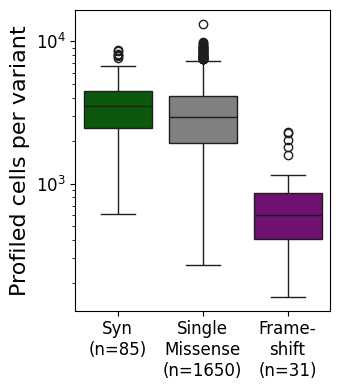

In [8]:
# Plot number of cells for each type of variant
df_profiles_toplot = df_profiles_merged.copy()
df_profiles_toplot['NCells_Tot'] = df_profiles_merged['NCells_R1']+df_profiles_merged['NCells_R2']
df_profiles_toplot['Variant Type'] = \
    pd.Categorical(df_profiles_merged['Variant_Class'].map({'Synonymous':'Syn',
                                                            'Single Missense':'Single\nMissense',
                                                            'Frameshift':'Frame-\nshift'}), 
                   categories=['Syn','Single\nMissense','Frame-\nshift'], ordered=True)
fig,ax=plt.subplots(figsize=(3.5,4))
boxplot_with_significance(
    df_profiles_toplot,
    x_col="Variant Type",
    y_col="NCells_Tot",
    hue_col=None,
    order=['Syn','Single\nMissense','Frame-\nshift'],
    palette={'Syn':'darkgreen',
             'Single\nMissense':'grey',
             'Frame-\nshift':'purple'},
    alpha=0.001,
    pairs=None,            # list of (group1, group2) pairs to compare
    shared_label="***",    # text to show if any comparison is p < alpha
    offset=0.02,
    anno_sample_sizes=True,
    ax=ax
)
ax.set_yscale('log')
ax.set_xlabel("")
ax.set_ylabel('Profiled cells per variant', fontsize=16)
ax.tick_params(labelsize=12)
plt.tight_layout()
plt.show()
fig.savefig('./consensus_plots/ntotalcells.LMNA.052725.pdf', dpi=600)


In [222]:
# Plot grey Single Missense points first (in the back) with lower alpha

# Split the data into grey points and other points
subset_grey = df_profiles_merged[df_profiles_merged['Variant_Class'] == 'Single Missense']
subset_color = df_profiles_merged[df_profiles_merged['Variant_Class'] != 'Single Missense']

# Create the figure and axis
fig, ax = plt.subplots(figsize=(4, 4))

sns.scatterplot(data=subset_grey, 
                x='UMAP1', 
                y='UMAP2', 
                color='grey', 
                s=40, 
                alpha=0.3,
                ax=ax)

# Plot the colored points on top
sns.scatterplot(data=subset_color, 
                x='UMAP1', 
                y='UMAP2', 
                hue='Variant_Class',
                palette={'Synonymous': 'green',
                         'Single Missense': 'grey',
                         'Frameshift': 'purple'},
                s=40,
                ax=ax)

# Create custom legend entries
synonymous_legend = mlines.Line2D([], [], color='green', marker='o', linestyle='',
                                  markersize=6, label='Syn')
single_missense_legend = mlines.Line2D([], [], color='grey', marker='o', linestyle='',
                                       markersize=6, alpha=0.3, label='Single\nMissense')
frameshift_legend = mlines.Line2D([], [], color='purple', marker='o', linestyle='',
                                  markersize=6, label='Frameshift')

# Add the custom legend
ax.legend(handles=[synonymous_legend, single_missense_legend, frameshift_legend],
          markerscale=1.2,
          title='Variant Type',
          loc='upper right',
          fontsize=10,
          title_fontsize=12)

# Remove x-axis and y-axis tick labels and ticks
plt.xticks([])
plt.yticks([])

# Label axes
plt.xlabel('UMAP 1', fontsize=16)
plt.ylabel('UMAP 2', fontsize=16)
plt.tight_layout()

# Save the figure
fig.savefig('./consensus_plots/LMNAT3.UMAP.011025.pdf', dpi=600)
plt.close()


In [149]:
# Plot by TO aa in variant
amino_acids_list = [
    'A',  # Alanine
    'R',  # Arginine
    'N',  # Asparagine
    'D',  # Aspartic acid
    'C',  # Cysteine
    'E',  # Glutamic acid
    'Q',  # Glutamine
    'G',  # Glycine
    'H',  # Histidine
    'I',  # Isoleucine
    'L',  # Leucine
    'K',  # Lysine
    'M',  # Methionine
    'F',  # Phenylalanine
    'P',  # Proline
    'S',  # Serine
    'T',  # Threonine
    'W',  # Tryptophan
    'Y',  # Tyrosine
    'V'   # Valine
]
#sns.set_theme(rc={'figure.figsize':(6,6)})
#sns.set_style("whitegrid", {'axes.grid' : False})

for aa in amino_acids_list:
    print(aa)
    variants_assayed_umap_toplot = \
        df_profiles_merged\
            [df_profiles_merged['Variant_Class'].isin(['Single Missense','Synonymous'])]
    variants_assayed_umap_toplot['Label'] = variants_assayed_umap_toplot\
        .apply(lambda row: 'Syn' if row['Variant_Class']=='Synonymous' else aa if row['Variant'][-1]==aa else 'not'+aa, axis=1)
    variants_assayed_umap_toplot['zorder'] = \
        variants_assayed_umap_toplot['Label'].map(lambda x: 0 if x=='not'+aa else 1 if x=='Syn' else 2)
    variants_assayed_umap_toplot.sort_values(by='zorder',inplace=True)
    fig,ax=plt.subplots(figsize=(4,4))
    sns.scatterplot(data=variants_assayed_umap_toplot, 
                    x='UMAP1', y='UMAP2', 
                    hue='Label', 
                    palette={'Syn':'green',
                             aa:'red',
                             'not'+aa:'blue'},
                    s=20,
                    ax=ax)
    # Remove tick labels and ticks
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    fig.savefig('./consensus_plots/umaps_aato/'+aa+'.pdf')
    plt.close()


A
R
N
D
C
E
Q
G
H
I
L
K
M
F
P
S
T
W
Y
V


In [150]:
# Plot all positions
variants_assayed_umap_toplot = \
    df_profiles_merged\
        [df_profiles_merged['Variant_Class'].isin(['Single Missense','Synonymous'])]
# Library
start_pos = 178
end_pos = 273

# Make plots
for aa_pos in range(start_pos,end_pos+1):
    num_variants = \
        sum(variants_assayed_umap_toplot['Variant']\
                .map(lambda x: int(x[1:-1])).values == aa_pos)
    if num_variants >= 2:
        variants_assayed_umap_toplot['Label'] = variants_assayed_umap_toplot\
            .apply(lambda row: 'Syn' if row['Variant_Class']=='Synonymous' \
                                   else str(aa_pos) if ((int(row['Variant'][1:-1]) == aa_pos) & (row['Variant_Class']=='Single Missense')) \
                                   else 'Other', axis=1)\
            .astype('category')\
            .cat.reorder_categories(['Other', 'Syn', str(aa_pos)], ordered=True)
        variants_assayed_umap_toplot['zorder'] = \
            variants_assayed_umap_toplot['Label'].map(lambda x: 0 if x=='Other' else 1 if x=='Syn' else 2)
        variants_assayed_umap_toplot.sort_values(by='zorder',inplace=True)
        fig,ax=plt.subplots(figsize=(4,4))
        sns.scatterplot(data=variants_assayed_umap_toplot, 
                        x='UMAP1', y='UMAP2', 
                        hue='Label', 
                        palette={'Syn':'green',
                                 str(aa_pos):'red',
                                 'Other':'#D3D3D3'},
                        s=25,
                        ax=ax)
        text_annos = []
        for q,row in variants_assayed_umap_toplot[variants_assayed_umap_toplot['Label']==str(aa_pos)].iterrows():
            text_annos.append(\
                ax.text(x=row['UMAP1'], 
                        y=row['UMAP2'], 
                        s=row['Variant'], 
                        fontsize=12, 
                        color='black')
                             )
        adjust_text(text_annos,
                    expand_points=(1,1),
                    arrowprops=dict(
                        arrowstyle="-", 
                        color='black', 
                        lw=2
                        ),
                    ax=ax
                    )
        # Remove tick labels and ticks
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        fig.savefig('./consensus_plots/umaps_byposition/' + \
                        'variant_umap_AA' + str(aa_pos) + '.png')
        plt.close()


9 [-0.36034579 -0.94003418]
12 [0.19212488 0.69366464]
5 [-0.27986518 -0.80460232]
12 [-0.66945973 -0.44336368]


In [49]:
# Perform Louvain clustering
labels,nclust = \
    cluster_louvain(
        variant_medianplusemd_pca,
        k=25,
        metric='cosine',
        weighted=False
    )
df_profiles_merged['Louvain Cluster'] = labels


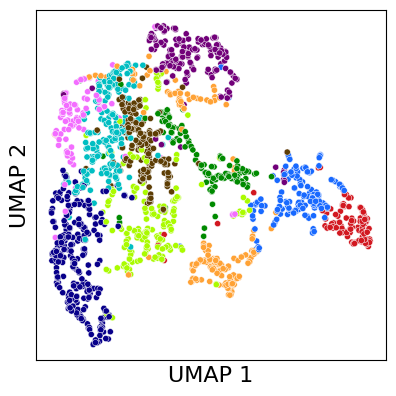

In [47]:
# Look at UMAP clusters
palette25cat = ['#d21820', '#1869ff', '#008a00', '#f36dff', '#710079', '#aafb00', '#00bec2', '#ffa235', '#5d3d04', 
                '#08008a', '#005d5d', '#9a7d82', '#a2aeff', '#96b675', '#9e28ff', '#4d0014', '#ffaebe', '#ce0092', 
                '#00ffb6', '#002d00', '#9e7500', '#3d3541', '#f3eb92', '#65618a', '#8a3d4d']
fig,ax=plt.subplots(figsize=(4,4))
sns.scatterplot(data=df_profiles_merged,
                x='UMAP1',
                y='UMAP2',
                hue='Louvain Cluster',
                s=20,
                palette=palette25cat,
                ax=ax,
                legend=False)
#plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')

# Remove x-axis tick labels and ticks
plt.xticks([])
# Remove y-axis tick labels and ticks
plt.yticks([])
plt.tight_layout()

# Label x and y-axes
plt.xlabel('UMAP 1', fontsize=16)
plt.ylabel('UMAP 2', fontsize=16)
plt.show()
fig.savefig('./consensus_plots/LMNAT3.UMAP.louvainclusters.041225.pdf', dpi=600)


In [51]:
# Classify compartments of features and then cluster features
channel_to_dye = {
    'CH0': 'DAPI',
    'CH1': 'GFP-LMNA',
    'CH2': 'Ph+WGA',
    'CH3': 'Mitoprobe'
}
feat_selected_df = \
    pd.DataFrame(classify_features_with_dye(feat_common, channel_to_dye=channel_to_dye))
feat_selected_df['Imaging Channel'] = \
    feat_selected_df['associated_dye'].map(lambda x: 'Multiple' if ',' in x else 'None' if x=='' else x)
all_channels = ['None'] + list(channel_to_dye.values()) + ['Multiple']
feature_channel_palette = \
    {all_channels[i]:palette25cat[i+nclust] for i in range(len(all_channels))}


In [52]:
# Save Profiles
df_profiles_merged.to_csv('./consensus_profiles/LMNA_averaged_medianplusEMD_clusteringv2_021325.csv')


In [61]:
# Read profiles
df_profiles_merged = pd.read_csv('./consensus_profiles/LMNA_averaged_medianplusEMD_clusteringv2_021325.csv', index_col=None)
df_profiles_merged.drop(columns='Unnamed: 0',inplace=True)
df_profiles_merged['Variant_Class'] = \
    pd.Categorical(df_profiles_merged['Variant_Class'], categories=['Synonymous','Single Missense','Frameshift'], ordered=True)
features_common = [c for c in df_profiles_merged.columns if c not in ['Variant','Variant_Class',
                                                                      'NCells_R1','NCells_R2',
                                                                      'UMAP1','UMAP2',
                                                                      'Louvain Cluster']]


In [ ]:
# Define phenotyping impact scores
df_profiles_synmedian = \
    df_profiles_merged\
        .query('Variant_Class == "Synonymous"')\
        [features_common].agg(np.median)

# compute cosine similarity to median synonymous profile
variant_cosine_similarity = \
    cosine_similarity(df_profiles_merged[features_common], df_profiles_synmedian.values.reshape(1,-1))
df_profiles_merged['Morphological Impact Score'] = \
    (1-variant_cosine_similarity[:,0])/2


In [6]:
# Load aggregated feature medians / EMDs for both replicates, zscore and average them
median_df_r2 = \
    pd.read_parquet('./R2_features/LMNAT3R2.cellprofiler_122824.median.cellaggregated.parquet')
median_df_r1 = \
    pd.read_parquet('./R1_features/LMNAT3R1.cellprofiler_122824.median.cellaggregated.parquet')

EMD_df_r2 = \
    pd.read_csv('./R2_KStest_bycell/results/LMNA_T3R2.bycell.full_EMD.csv')
EMD_df_r1 = \
    pd.read_csv('./R1_KStest_bycell/results/LMNA_T3R1.bycell.full_EMD.csv')


In [ ]:
# Compute average of median features
variant_medians_merged = \
    prepare_consensus_variant_scores([median_df_r1,median_df_r2])
variant_medians_merged['Variant_Class'] = \
    pd.Categorical(
        variant_medians_merged['Variant'].astype(str).apply(variant_classification),
            categories=mutation_types, 
            ordered=True)
variant_medians_merged.to_csv('./consensus_profiles/LMNA_merged_featuremedians_010625.csv')

# Compute average of EMD features
variant_EMD_merged = \
    prepare_consensus_variant_scores([EMD_df_r1,EMD_df_r2], variant_col="Variant")
variant_EMD_merged['Variant_Class'] = \
    pd.Categorical(
        variant_EMD_merged['Variant'].astype(str).apply(variant_classification),
            categories=mutation_types, 
            ordered=True)
variant_EMD_merged.to_csv('./consensus_profiles/LMNA_merged_featureEMD_010925.csv')


In [63]:
# import medians and EMD merged
variant_medians_merged = pd.read_csv('./consensus_profiles/LMNA_merged_featuremedians_010625.csv')
variant_medians_merged.drop(columns='Unnamed: 0', inplace=True)
variant_EMD_merged = pd.read_csv('./consensus_profiles/LMNA_merged_featureEMD_010925.csv')
variant_EMD_merged.drop(columns='Unnamed: 0', inplace=True)


In [84]:
# Remove blocked features
# opening the file in read mode 
blocklist_file = open("feature_blocklist2.txt", "r") 
  
# reading the file 
blocked_features = blocklist_file.read() 
  
# replacing end of line('/n') with ' ' and 
# splitting the text it further when '.' is seen. 
blocked_features = blocked_features.split("\n")[1:-1]


In [85]:
# Make a df of all medians and EMD
variant_featuremediansEMD_bycluster_totest = \
    pd.merge(
        pd.merge(
            df_profiles_merged[['Variant',
                                'Louvain Cluster',
                                'Variant_Class'
                              ]],
            variant_medians_merged\
                .drop(columns=['Variant_Class']+[b for b in blocked_features if b in variant_medians_merged.columns])\
                .rename(columns={f:f+'_median' for f in variant_medians_merged.columns if f != 'Variant'}),
            on='Variant'
        ),
        variant_EMD_merged\
            .drop(columns=['Variant_Class']+[b for b in blocked_features if b in variant_EMD_merged.columns])\
            .rename(columns={f:f+'_EMD' for f in variant_EMD_merged.columns if f != 'Variant'}),
        on='Variant'
    )


In [86]:
# Split feature list into pieces of size 50
Nstep = 50
features_totest_split = [f for f in variant_featuremediansEMD_bycluster_totest.columns if f not in ['Variant','Louvain Cluster','Variant_Class']]
features_totest_split = \
    [features_totest_split[i*Nstep:(i+1)*Nstep] \
         for i in range((len(features_totest_split) + (Nstep-1))//Nstep)]


In [87]:
# merge to cluster identities and write them to folder
# Cut features into pieces for Mann-Whitney U Testing
counter=0
for feature_list_piece in features_totest_split:
    piece_name = './cluster_DEtesting/LMNA_T3.grouped.piece' + str(counter) + '.csv'
    features_to_subset = ['Variant','Louvain Cluster','Variant_Class'] + feature_list_piece
    df_partial_called_filt = variant_featuremediansEMD_bycluster_totest[features_to_subset]
    df_partial_called_filt\
        .to_csv(piece_name)
    counter+=1


In [ ]:
## RUN perform_MWU_test_bycluster.sh on a Sun Grid Engine Cluster environment!

In [88]:
# Combine feature p-values
counter = 0
cluster_pval_dfs = []
for feature_list_piece in features_totest_split:
    df_toimport = pd.read_csv('./cluster_DEtesting/results/LMNA_T3.MW.piece'+str(counter)+'.csv')
    cluster_pval_dfs.append(df_toimport.drop(columns='Unnamed: 0'))
    counter+=1

cluster_features_pvalues_df =\
    pd.concat(cluster_pval_dfs, axis=0)\
        .query('Mann_Whitney_p < 1')


In [89]:
# Save cluster feature p-values
cluster_features_pvalues_df.to_csv('./cluster_DEtesting/results/LMNA_cluster_feature_pval_df_021325.csv')


In [93]:
# Read cluster feature p-values
cluster_features_pvalues_df = \
    pd.read_csv('./cluster_DEtesting/results/LMNA_cluster_feature_pval_df_021325.csv')


In [94]:
# Relabel clusters
cluster_remap = \
    {
        0: 8,
        1: 9,
        2: 2,
        3: 10,
        4: 3,
        5: 4,
        6: 6,
        7: 7,
        8: 5,
        9: 1
    }
cluster_features_pvalues_df['Louvain Cluster'] = cluster_features_pvalues_df['Cluster']
cluster_features_pvalues_df['Cluster'] = \
    cluster_features_pvalues_df['Louvain Cluster'].map(lambda x: cluster_remap[x])


In [95]:
# Filter for marker features
cluster_features_pvalues_filt_df = \
    cluster_features_pvalues_df\
        .query('abs(Robust_Z) >= 1.5 & abs(Robust_Z_Syn) >= 1.5')\
        .sort_values(by="Mann_Whitney_p", ascending=True)\
        .reset_index()\
        .drop(columns=['index','Unnamed: 0'])
cluster_features_pvalues_filt_df.to_csv('./cluster_DEtesting/results/LMNA_cluster_features_filteredsorted_021325.csv')


In [96]:
# Set landmark features
landmark_features = \
    ['Mean_NucleiExpanded_Intensity_MeanIntensity_CH1',
     'Mean_NuclearBoundary_Intensity_MeanIntensity_CH1',
     'Mean_NucleiExpanded_Granularity_1_CH1',
     'Mean_Nuclei_AreaShape_FormFactor'
    ]
total_landmark_features = \
    [c+'_median' for c in landmark_features] + \
    [c+'_EMD' for c in landmark_features]


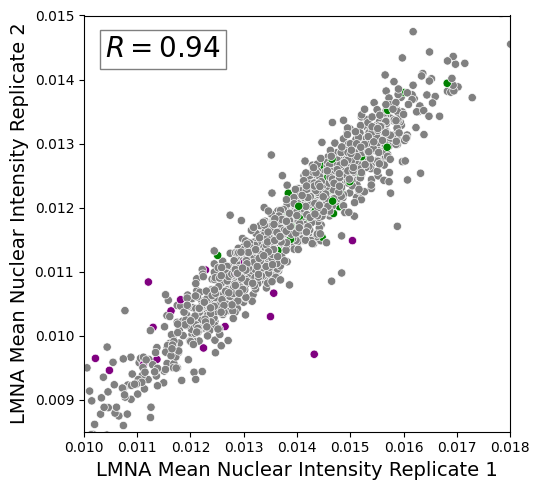

In [15]:
# Compute correlation plot between LMNA intensity
median_df_r1_forcorr = median_df_r1.copy()
median_df_r1_forcorr.index = median_df_r1_forcorr['aaChanges']
median_df_r2_forcorr = median_df_r2.copy()
median_df_r2_forcorr.index = median_df_r2_forcorr['aaChanges']

r1_meanintensity = median_df_r1_forcorr.loc[var_common,'Mean_NucleiExpanded_Intensity_MeanIntensity_CH1']
r2_meanintensity = median_df_r2_forcorr.loc[var_common,'Mean_NucleiExpanded_Intensity_MeanIntensity_CH1']

slope, intercept, r_value, p_value, std_err = ss.linregress(r1_meanintensity,r2_meanintensity)
r_squared = r_value**2

# Prepare line values for the best-fit line
line_x = np.linspace(r1_meanintensity.min(), r1_meanintensity.max(), 100)
line_y = slope * line_x + intercept

# Plot
fig, ax = plt.subplots(figsize=(5.5, 5))
df_profiles_merged_toplot = df_profiles_merged.copy()
df_profiles_merged_toplot.index = df_profiles_merged_toplot['Variant']
sns.scatterplot(x=r1_meanintensity, 
                y=r2_meanintensity, 
                hue=df_profiles_merged_toplot.loc[var_common,'Variant_Class'],
                palette=variant_type_palette,
                ax=ax,
                legend=False)
#ax.plot(line_x, line_y, color='red')

# Add labels
ax.set_xlabel('LMNA Mean Nuclear Intensity Replicate 1', fontsize=14)
ax.set_ylabel('LMNA Mean Nuclear Intensity Replicate 2', fontsize=14)

# Display R^2 on the plot
ax.text(
    0.05, 0.9, 
    f'$R = {r_value:.2f}$', 
    transform=ax.transAxes, 
    fontsize=20, 
    bbox=dict(facecolor='white', alpha=0.5)
)

# Show legend and plot
#ax.legend(loc='lower right', markerscale=2, fontsize=12)
plt.xlim((0.01,0.018))
plt.ylim((0.0085,0.015))
plt.tight_layout()
fig.savefig('./consensus_plots/LMNAT3.MeanNucIntensity.correlationbetweenreps.011325.pdf')
plt.show()


In [42]:
# import KS statistics
variant_feature_pvalues_rep1_df = pd.read_csv('./R1_KStest_bycell/results/LMNA_T3R1.bycell.full_p_values.csv')
variant_feature_pvalues_rep1_df.index = variant_feature_pvalues_rep1_df['Variant']
variant_feature_pvalues_rep1_df = variant_feature_pvalues_rep1_df.drop('Variant', axis=1)

variant_feature_pvalues_rep2_df = pd.read_csv('./R2_KStest_bycell/results/LMNA_T3R2.bycell.full_p_values.csv')
variant_feature_pvalues_rep2_df.index = variant_feature_pvalues_rep2_df['Variant']
variant_feature_pvalues_rep2_df = variant_feature_pvalues_rep2_df.drop('Variant', axis=1)


In [43]:
# perform meta analysis to combine p-values
df_KSpvalues_merged = pd.DataFrame(index=df_profiles_merged['Variant'],
                                   columns=variant_feature_pvalues_rep1_df.columns)
for v in df_profiles_merged['Variant']:
    for f in variant_feature_pvalues_rep1_df.columns:
        df_KSpvalues_merged.loc[v,f] = \
            ss.combine_pvalues([variant_feature_pvalues_rep1_df.loc[v,f], 
                                variant_feature_pvalues_rep2_df.loc[v,f]],
                               method='fisher'
                              )[1]
                       


KeyboardInterrupt



In [ ]:
# Save meta-analysis merged p-values
df_KSpvalues_merged.to_csv('./consensus_profiles/LMNA_merged_KSpvalues_010924.csv')


In [44]:
# Load meta-analysis merged p-values
df_KSpvalues_merged = \
    pd.read_csv('./consensus_profiles/LMNA_merged_KSpvalues_010924.csv')
df_KSpvalues_merged.index = df_KSpvalues_merged['Variant']
df_KSpvalues_merged.drop(columns='Variant',inplace=True)
df_KSpvalues_merged


,AreaShape_Area,AreaShape_Compactness,AreaShape_ConvexArea,AreaShape_Eccentricity,AreaShape_EquivalentDiameter,AreaShape_EulerNumber,AreaShape_Extent,AreaShape_FormFactor,AreaShape_MajorAxisLength,AreaShape_MaxFeretDiameter,...,Neighbors_AngleBetweenNeighbors_30,Neighbors_AngleBetweenNeighbors_Adjacent,Neighbors_FirstClosestDistance_30,Neighbors_FirstClosestDistance_Adjacent,Neighbors_NumberOfNeighbors_30,Neighbors_NumberOfNeighbors_Adjacent,Neighbors_PercentTouching_30,Neighbors_PercentTouching_Adjacent,Neighbors_SecondClosestDistance_30,Neighbors_SecondClosestDistance_Adjacent
Variant,,,,,,,,,,,,,,,,,,,,,
D192S,9.857482e-49,3.408472e-09,8.303331e-50,0.005967,9.857482e-49,0.995845,0.000223,3.408472e-09,9.652052e-40,5.493631e-42,...,0.171741,0.171741,4.286838e-07,4.286838e-07,0.000003,8.911795e-08,0.003054,2.115777e-01,4.485669e-13,4.485669e-13
V191P,3.976364e-04,1.078197e-05,1.379947e-04,0.006857,3.976364e-04,1.000000,0.000788,1.078197e-05,7.798673e-04,3.262843e-03,...,0.095132,0.095132,2.619582e-01,2.619582e-01,0.043777,3.649250e-03,0.050016,6.782607e-03,2.539580e-01,2.539580e-01
L183F,2.705003e-49,2.210609e-06,2.408289e-48,0.024279,2.705003e-49,1.000000,0.004184,2.210609e-06,8.365478e-37,5.470395e-35,...,0.580783,0.580783,5.974227e-09,5.974227e-09,0.000019,4.797197e-06,0.000689,9.955460e-01,2.696050e-11,2.696050e-11
L215M,1.640053e-01,6.521886e-01,2.892197e-01,0.551624,1.640053e-01,1.000000,0.079901,6.521886e-01,1.118717e-01,7.711824e-02,...,0.233067,0.233067,6.122791e-01,6.122791e-01,0.236009,9.998300e-01,0.859077,8.376253e-01,5.162201e-01,5.162201e-01
L226V,2.759276e-01,2.119067e-01,3.577412e-01,0.533750,2.759276e-01,1.000000,0.695393,2.119067e-01,3.137328e-01,2.606001e-01,...,0.058279,0.058279,1.048256e-01,1.048256e-01,0.016915,1.298532e-02,0.000033,6.199276e-05,2.361359e-01,2.361359e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R225S,9.188564e-03,7.360257e-03,2.565456e-03,0.079451,9.188564e-03,0.987795,0.067141,7.360257e-03,7.172185e-04,1.515821e-03,...,0.160785,0.160785,2.904984e-01,2.904984e-01,0.000013,3.598992e-09,0.000038,2.463356e-11,1.827595e-02,1.827595e-02
Q251H,8.626377e-02,3.582509e-01,1.043276e-01,0.387916,8.626377e-02,1.000000,0.584263,3.582509e-01,3.716790e-01,1.146251e-01,...,0.676030,0.676030,6.001332e-01,6.001332e-01,0.526789,6.883714e-01,0.756760,1.449388e-01,3.787303e-01,3.787303e-01
Y211F,3.442036e-03,4.102846e-03,7.451172e-04,0.100907,3.442036e-03,1.000000,0.045520,4.102846e-03,2.811761e-04,8.335478e-05,...,0.890845,0.890845,6.661319e-01,6.661319e-01,0.976031,9.985015e-01,0.831138,8.956963e-01,2.922389e-01,2.922389e-01


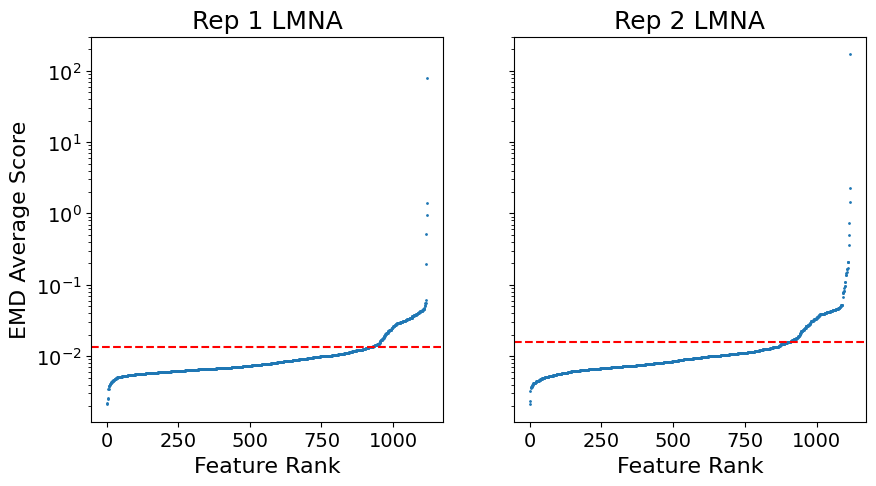

In [45]:
# Look at reproducibility plot of EMD - reps 1 and 2
# remove non-reproducible features
df_WTemd_rep2 = pd.read_csv('./R2_KStest_bycell/results/LMNAT3R2_WT_EMDreplicates.csv')
df_WTemd_rep2.drop(columns='Unnamed: 0',inplace=True)
df_WTemd_rep1 = pd.read_csv('./R1_KStest_bycell/results/LMNAT3R1_WT_EMDreplicates.csv')
df_WTemd_rep1.drop(columns='Unnamed: 0',inplace=True)

# Plot and filter by replicate separately
df_WTemd_rep1_avg = df_WTemd_rep1.mean(axis=0)
df_WTemd_rep1_avg_sorted = df_WTemd_rep1_avg.sort_values(ascending=True)
emd_score_WT_Q3_rep1 = np.percentile(df_WTemd_rep1_avg_sorted,75)
emd_score_WT_Q1_rep1 = np.percentile(df_WTemd_rep1_avg_sorted,25)
emd_score_WT_IQR_rep1 = emd_score_WT_Q3_rep1 - emd_score_WT_Q1_rep1
emd_score_WT_thresh_rep1 = 1.5*emd_score_WT_IQR_rep1 + emd_score_WT_Q1_rep1 # 1.5 x IQR plus Q1

df_WTemd_rep2_avg = df_WTemd_rep2.mean(axis=0)
df_WTemd_rep2_avg_sorted = df_WTemd_rep2_avg.sort_values(ascending=True)
emd_score_WT_Q3_rep2 = np.percentile(df_WTemd_rep2_avg_sorted,75)
emd_score_WT_Q1_rep2 = np.percentile(df_WTemd_rep2_avg_sorted,25)
emd_score_WT_IQR_rep2 = emd_score_WT_Q3_rep2 - emd_score_WT_Q1_rep2
emd_score_WT_thresh_rep2 = 1.5*emd_score_WT_IQR_rep2 + emd_score_WT_Q1_rep2 # 1.5 x IQR plus Q1

fig,axs=plt.subplots(ncols=2, figsize=(10,5), sharey=True)
axs[0].scatter(list(range(1,len(df_WTemd_rep1_avg_sorted.index)+1)),
            df_WTemd_rep1_avg_sorted,
            s=1)
axs[0].axhline(y=emd_score_WT_thresh_rep1, color='r', linestyle='--')
axs[1].scatter(list(range(1,len(df_WTemd_rep2_avg_sorted.index)+1)),
            df_WTemd_rep2_avg_sorted,
            s=1)
axs[1].axhline(y=emd_score_WT_thresh_rep2, color='r', linestyle='--')


axs[0].set_yscale('log')
axs[1].set_yscale('log')

axs[0].set_ylabel('EMD Average Score', fontsize=16)

axs[0].set_xlabel('Feature Rank', fontsize=16)
axs[1].set_xlabel('Feature Rank', fontsize=16)

axs[0].set_title('Rep 1 LMNA', fontsize=18)
axs[1].set_title('Rep 2 LMNA', fontsize=18)

axs[0].tick_params(axis='both',labelsize=14)
axs[1].tick_params(axis='both',labelsize=14)

plt.show()
fig.savefig('./consensus_plots/EMD_reproducibility_byreplicate_011324.pdf', dpi=600)

features_reproducible = \
    (df_WTemd_rep1_avg<=emd_score_WT_thresh_rep1) & (df_WTemd_rep2_avg<=emd_score_WT_thresh_rep2)
features_reproducible = features_reproducible.index[features_reproducible]


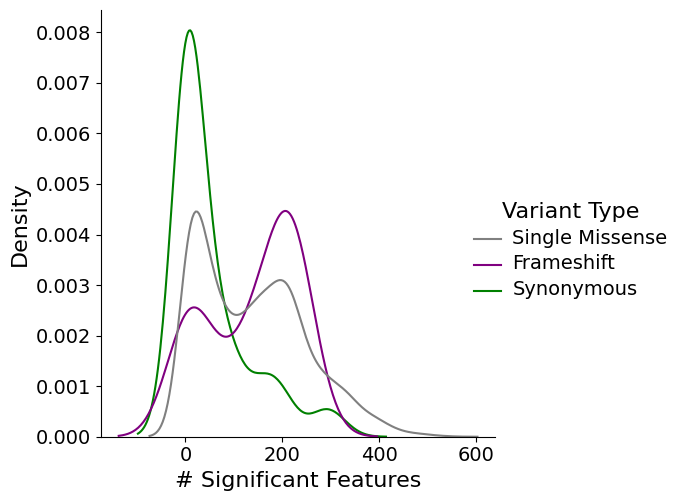

In [46]:
# Make plot of number of significant features using p-values computed on _CELLS_ aggregated data, using KS test
# Filter for reproducible features
# Remove puncta/line features
features_reproducible_filtered = \
    [f for f in features_reproducible if ('Puncta' not in f) & ('Line' not in f)]

df_KSpvalues_merged_filt = \
    df_KSpvalues_merged[features_reproducible_filtered]

# Remove features which are significantly different in >90% of variants - often discrete features
upper_sig_thresh = 0.9
features_overly_sig_toremove = \
    ~((df_KSpvalues_merged_filt <= 0.01).sum() \
          > upper_sig_thresh*len(df_KSpvalues_merged_filt)).values
df_KSpvalues_merged_filt = \
    df_KSpvalues_merged_filt.loc[:, features_overly_sig_toremove]

# Set Bonferroni FDR at q<=10^-3
p_value_thresh = 0.001/(np.prod(df_KSpvalues_merged_filt.shape)) # BONFERRONI FDR

variant_bycell_numsigfeatures = \
    (df_KSpvalues_merged_filt <= p_value_thresh).sum(axis=1).reset_index()
variant_bycell_numsigfeatures = \
    variant_bycell_numsigfeatures[variant_bycell_numsigfeatures['Variant']!='sig_gene_count']
variant_bycell_numsigfeatures.rename({0:'Num Significant Features'}, axis=1, inplace=True)
variant_bycell_numsigfeatures['Variant_Class'] = \
    pd.Categorical(variant_bycell_numsigfeatures['Variant'].astype(str).apply(variant_classification),
                   categories=['Single Missense','Frameshift','Synonymous'], ordered=True)

#fig,ax=plt.subplots(figsize=(8,6))
num_sig_features_plot = \
    sns.displot(data=variant_bycell_numsigfeatures,
                 x="Num Significant Features", 
                 hue="Variant_Class",
                 kind='kde',
                 palette=variant_type_palette,
                 legend=True,
                 common_norm=False)
plt.ylabel('Density', fontsize=16)
plt.xlabel('# Significant Features', fontsize=16)
plt.tick_params(axis='both',labelsize=14)

# Access the legend object from the FacetGrid
legend = num_sig_features_plot._legend

# Change the legend title font size
legend.set_title("Variant Type", prop={'size': 16})

# Change the legend labels font size
plt.setp(legend.get_texts(), fontsize=14)

num_sig_features_plot.savefig('./consensus_plots/KStest_numsigfeatures_byvariantclass_011324.pdf')
plt.show()


In [47]:
# What are the variants with the most differential features?
variant_bycell_numsigfeatures\
    .sort_values(by='Num Significant Features', ascending=False)[0:10]


,Variant,Num Significant Features,Variant_Class
107,D272W,529,Single Missense
827,D185P,494,Single Missense
246,Y267S,491,Single Missense
108,Y267R,487,Single Missense
1682,R196W,473,Single Missense
1216,K260C,466,Single Missense
1229,K201P,452,Single Missense
837,Q198W,445,Single Missense
1368,Y267D,442,Single Missense
1721,F206A,438,Single Missense


In [152]:
# Cluster highly significant features over p-value data
n_variants_thresh_highlysig = 25
eps=10**(-20)
variant_feature_logp_df = \
    -np.log10(df_KSpvalues_merged_filt+eps)
highly_sig_features = \
    (df_KSpvalues_merged_filt <= p_value_thresh).sum(axis=0) >= n_variants_thresh_highlysig
highly_sig_features = \
    highly_sig_features[highly_sig_features].index
variant_feature_logp_df_filtered = \
    variant_feature_logp_df.loc[:,highly_sig_features]


In [225]:
# Function to classify features from various compartments

# Define autopct function to hide labels below 1%
def autopct_hide_small(pct):
    return f'{pct:.1f}%' if pct >= 3 else ''

# Classify the features with dyes
channel_to_dye_dict = {
    'CH0': 'DAPI',
    'CH1': 'GFP-LMNA',
    'CH2': 'Ph+WGA',
    'CH3': 'Mitoprobe'
}
classified_features = \
    classify_features_with_dye(features_reproducible_filtered, 
                               channel_to_dye=channel_to_dye_dict
                              )

# Convert results to DataFrame and display
feature_df = pd.DataFrame(classified_features)
feature_df['Imaging Channel'] = \
    feature_df['associated_dye'].map(lambda x: 'Multiple' if ',' in x else 'None' if x=='' else x)

# Count the occurrences of each compartment
channel_counts = feature_df['Imaging Channel'].value_counts()
channel_palette = {
    'DAPI': 'darkblue',
    'GFP-LMNA': 'lime',
    'None': 'grey',
    'Ph+WGA': 'orange',
    'Mitoprobe': 'darkred',
    'Multiple': 'purple',
}

# Function to classify features from various compartments
# Classify the features with dyes
classified_hs_features = \
    classify_features_with_dye(highly_sig_features, 
                               channel_to_dye=channel_to_dye_dict
                              )

# Convert results to DataFrame and display
highly_sig_feature_df = pd.DataFrame(classified_hs_features)
highly_sig_feature_df['Imaging Channel'] = \
    highly_sig_feature_df['associated_dye'].map(lambda x: 'Multiple' if ',' in x else 'None' if x=='' else x)

# Count the occurrences of each compartment
channel_counts = highly_sig_feature_df['Imaging Channel'].value_counts()


In [226]:
# Function to classify features from various compartments
# Classify the features with dyes
classified_features = \
    classify_compartment(features_reproducible_filtered)

# Convert results to DataFrame and display
feature_df['Compartment'] = classified_features

# Count the occurrences of each compartment
compartment_counts = feature_df['Compartment'].value_counts()

# Function to classify features from various compartments
# Classify the features with dyes
classified_hs_features = \
    classify_compartment(highly_sig_features)

# Convert results to DataFrame and display
highly_sig_feature_df['Compartment'] = classified_hs_features

# Count the occurrences of each compartment
compartment_counts = highly_sig_feature_df['Compartment'].value_counts()


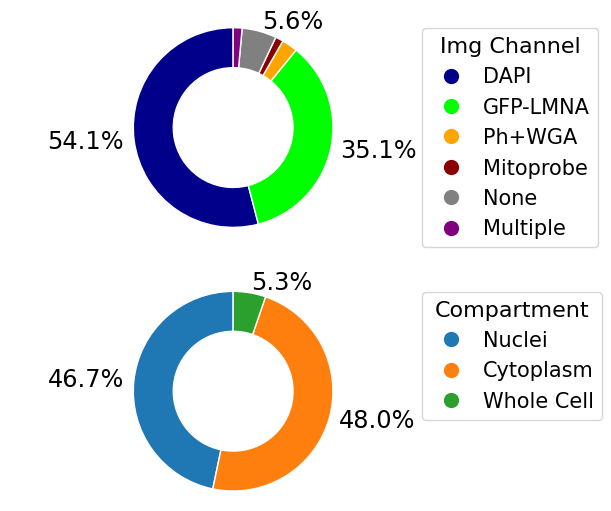

In [227]:
# Donut put
# --- user‐defined order lists ---
channel_order = ['DAPI', 'GFP-LMNA', 'Ph+WGA', 'Mitoprobe', 'None', 'Multiple']
compartment_order = ['Nuclei', 'Cytoplasm', 'Whole Cell']  # example—swap with your real categories

# reindex your counts to force that order (and drop any categories not in your order list)
vals1 = channel_counts.reindex(channel_order).fillna(0)
vals2 = compartment_counts.reindex(compartment_order).fillna(0)

# compute labels
pcts1 = vals1.values / vals1.sum() * 100
labels1 = [f'{p:.1f}%' if p >= 5 else '' for p in pcts1]
pcts2 = vals2.values / vals2.sum() * 100
labels2 = [f'{p:.1f}%' if p >= 5 else '' for p in pcts2]

# shared styling
fig, axs = plt.subplots(2, 1, figsize=(6,5), constrained_layout=True)
wedge_props = {'width': 0.4, 'edgecolor': 'white'}

# --- Top donut: Imaging Channel ---
colors1 = [channel_palette[k] for k in vals1.index]
wedges1, texts1 = axs[0].pie(
    vals1,
    labels=labels1,
    labeldistance=1.1,
    startangle=90,
    wedgeprops=wedge_props,
    textprops=dict(color='black', fontsize='xx-large'),
    colors=colors1
)
axs[0].axis('equal')
# build dot‐style proxies
dot_handles1 = [
    mlines.Line2D([0], [0],
           marker='o',
           color='w',                # no connecting line
           markerfacecolor=col,
           markersize=12,
           label=lab)
    for lab, col in zip(vals1.index, colors1)
]

axs[0].legend(
    handles=dot_handles1,
    title='Img Channel',
    loc='upper left',
    bbox_to_anchor=(0.9,1.2),
    fontsize=15,
    title_fontsize=16,
    handletextpad=0.5,   # space between dot and text
)
# --- Bottom donut: Compartment ---
# choose or define your own color palette here:
colors2 = plt.cm.tab10.colors[:len(vals2)]
wedges2, texts2 = axs[1].pie(
    vals2,
    labels=labels2,
    labeldistance=1.1,
    startangle=90,
    wedgeprops=wedge_props,
    textprops=dict(color='black', fontsize='xx-large'),
    colors=colors2
)
axs[1].axis('equal')
dot_handles2 = [
    mlines.Line2D([0], [0],
           marker='o',
           color='w',
           markerfacecolor=col,
           markersize=12,
           label=lab)
    for lab, col in zip(vals2.index, colors2)
]

axs[1].legend(
    handles=dot_handles2,
    title='Compartment',
    loc='upper left',
    bbox_to_anchor=(0.9,1),
    fontsize=15,
    title_fontsize=16,
    handletextpad=0.5,
)

plt.show()
fig.savefig('./consensus_plots/LMNAT3.donutchart.KSbonferronicorrected.hitfeatures.052925.pdf')
